# CNN desde cero
### Creación del modelo

El tercer notebook está compuesto por la arquitectura del modelo y su creación gracias al entrenamiento, la validación y, después, el testing con nuevas imágenes. Se incluyen las gráficas de la exactitud (accuracy) y la pérdida (loss) para el entrenamiento y la validación durante varias época, la matriz de confusión, la curva ROC y la visualización de las imágenes mal clasificadas.

Este no es el modelo final, pero sirve para tener una idea.

Para empezar se importan algunas librerías.

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint
from tensorflow.keras.models import Model, model_from_json
from tensorflow.keras import backend

import numpy as np
from numpy.random import seed
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os

Se llaman los directorios ya creados anteriormente.

In [2]:
base_dir = 'RBC_recort_reesc'
dataset_resized = 'dataset_resized'

# Directories for the training, validation, and test
train_dir_2 = os.path.join(dataset_resized, 'train2')
validation_dir = os.path.join(dataset_resized, 'validation')
test_dir = os.path.join(dataset_resized, 'test')

# Directories with esquistocitos/no_esquistocitos pictures
train_esq_dir_2 = os.path.join(train_dir_2, '1_esquistocitos')
train_noesq_dir_2 = os.path.join(train_dir_2, '0_no_esquistocitos')

validation_esq_dir = os.path.join(validation_dir, '1_esquistocitos')
validation_noesq_dir = os.path.join(validation_dir, '0_no_esquistocitos')

test_esq_dir = os.path.join(test_dir, '1_esquistocitos')
test_noesq_dir = os.path.join(test_dir, '0_no_esquistocitos')

In [3]:
# Dimensiones de las imágenes de entrada
img_width, img_height = 220, 220

A continuación se construye la estructura del modelo gracias a los módulos de Keras. La arquitectura contiene capas convolucionales, capas de submuestreo (pooling), una capa para aplanar las neuronas, una de regularización mediante Dropout, y dos completamente conectadas, la última para finalmente hacer una clasificación binaria.

In [4]:
# Modelo
from keras import models
from keras import layers, regularizers
model = models.Sequential([
    
    # block 1
    layers.Conv2D(filters=16, kernel_size=(3,3), data_format='channels_last', name='conv_1', activation='relu',
                  input_shape=(img_width,img_height,3)),
    layers.MaxPool2D(pool_size=(2,2), name='pool_1'),
    
    # block 2
    layers.Conv2D(filters=16, kernel_size=(3,3), data_format='channels_last', name='conv_2', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), name='pool_2'),
    
    # block 3
    layers.Conv2D(filters=16, kernel_size=(3,3), data_format='channels_last', name='conv_3', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), name='pool_3'),
    
    # block 4
    layers.Conv2D(filters=16, kernel_size=(3,3), data_format='channels_last', name='conv_4', activation='relu'),
    layers.MaxPool2D(pool_size=(2,2), name='pool_4'),
    
    
    layers.Flatten(),
    layers.Dropout(0.5),
    layers.Dense(units=16, name='fc_1', activation='relu', kernel_regularizer=tf.keras.regularizers.l2((0.001))),
    layers.Dense(units=1, name='output', activation='sigmoid')
])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_1 (Conv2D)              (None, 218, 218, 16)      448       
_________________________________________________________________
pool_1 (MaxPooling2D)        (None, 109, 109, 16)      0         
_________________________________________________________________
conv_2 (Conv2D)              (None, 107, 107, 16)      2320      
_________________________________________________________________
pool_2 (MaxPooling2D)        (None, 53, 53, 16)        0         
_________________________________________________________________
conv_3 (Conv2D)              (None, 51, 51, 16)        2320      
_________________________________________________________________
pool_3 (MaxPooling2D)        (None, 25, 25, 16)        0         
_________________________________________________________________
conv_4 (Conv2D)              (None, 23, 23, 16)        2

Se compila el modelo con un optimizador, la función de pérdida y la métrica para juzgar el rendimiento del modelo.

In [5]:
# Compilación del modelo

model.compile(optimizer = tf.keras.optimizers.SGD(),
             loss = tf.keras.losses.BinaryCrossentropy(),
             metrics = ['accuracy'])

Las píxeles de las imágenes se normalizan para simplificar el entrenamiento. Además se crean dos generadores, uno para training y otro para validación, cada uno de ellos con el directorio correspondiente.

In [6]:
batch_size_train = 100
batch_size_val = 100

# Se reescalan todas las imágenes
train_datagen = ImageDataGenerator(rescale = 1.0/255.)
test_datagen = ImageDataGenerator(rescale = 1.0/255.)

# Imágenes de training de flujo en lotes (batches) de 100 usando el generador train_datagen
train_generator = train_datagen.flow_from_directory(train_dir_2,
                                                   batch_size = batch_size_train,
                                                   class_mode='binary',
                                                   target_size=(img_height, img_width))

# Imágenes de validación de flujo en lotes (batches) de 100 usando el generador test_datagen
validation_generator = test_datagen.flow_from_directory(validation_dir,
                                                       batch_size=batch_size_val,
                                                       class_mode='binary',
                                                       target_size=(img_height, img_width))


Found 6000 images belonging to 2 classes.
Found 400 images belonging to 2 classes.


In [7]:
# Se cuenta el número de muestras de los tres conjuntos
muestras_train = len(os.listdir(train_esq_dir_2)+(os.listdir(train_noesq_dir_2)))
print (muestras_train)

muestras_validation = len(os.listdir(validation_esq_dir)+(os.listdir(validation_noesq_dir)))
print (muestras_validation)

muestras_test = len(os.listdir(test_esq_dir)+(os.listdir(test_noesq_dir)))
print (muestras_test)

6000
400
1400


Se entrena el modelo con los dos generadores, el número de épocas especificadas y el número de pasos por cada una establecido como el valor resultante de dividir el número de muestras por el tamaño del lote.

In [8]:
# Entrenamiento del modelo
history = model.fit(
    train_generator,
    steps_per_epoch = muestras_train // batch_size_train,
    epochs = 30,
    validation_data = validation_generator,
    validation_steps = muestras_validation // batch_size_val,
    shuffle = False,
    verbose = 1)

Epoch 1/30
60/60 [==============================] - 24s 392ms/step - loss: 0.7230 - accuracy: 0.5288 - val_loss: 0.7221 - val_accuracy: 0.6525
Epoch 2/30
60/60 [==============================] - 24s 393ms/step - loss: 0.7142 - accuracy: 0.5767 - val_loss: 0.7210 - val_accuracy: 0.5050
Epoch 3/30
60/60 [==============================] - 24s 393ms/step - loss: 0.6976 - accuracy: 0.6420 - val_loss: 0.7203 - val_accuracy: 0.5100
Epoch 4/30
60/60 [==============================] - 24s 392ms/step - loss: 0.6623 - accuracy: 0.7020 - val_loss: 0.7125 - val_accuracy: 0.5975
Epoch 5/30
60/60 [==============================] - 24s 393ms/step - loss: 0.6074 - accuracy: 0.7225 - val_loss: 0.7431 - val_accuracy: 0.5000
Epoch 6/30
60/60 [==============================] - 24s 393ms/step - loss: 0.4821 - accuracy: 0.8082 - val_loss: 0.8296 - val_accuracy: 0.5000
Epoch 7/30
60/60 [==============================] - 24s 393ms/step - loss: 0.4419 - accuracy: 0.8193 - val_loss: 0.8330 - val_accuracy: 0.5025

In [9]:
# Saving the model
 model.save('modelo.h5')

Como se observa, por cada época se ha calculado la pérdida y la métrica establecida (accuracy) tanto para el training como para la validation. Normalmente, la exactitud de la validación es inferior, aunque a medida que pasan las iteraciones, lo ideal sería que el valor vaya aumentando.

A continuación se evalúa el modelo con las imágenes de test.

In [10]:
# Evaluación del modelo para obtener la accuracy con el conjunto de test

batch_size = 1

test_generator = test_datagen.flow_from_directory(test_dir,
                                                 batch_size=batch_size,
                                                 class_mode='binary',
                                                 target_size=(img_height, img_width),
                                                 shuffle=False)

evaluation = model.evaluate(test_generator,
                            steps=muestras_test,
                            verbose=1)

Found 1400 images belonging to 2 classes.
1400/1400 [==============================] - 6s 4ms/step - loss: 0.2782 - accuracy: 0.8936


Se obtiene la pérdida y la exactitud final después de la evaluación.

Para visualizar los resultados, primero se grafican la pérdida y la exactitud tanto para el training y la validation. Es decir, los valores obtenidos a lo largo de las épocas.

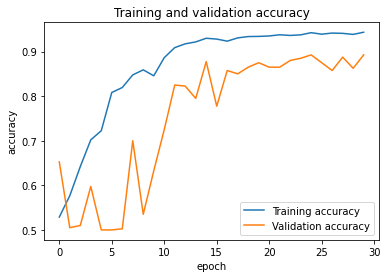

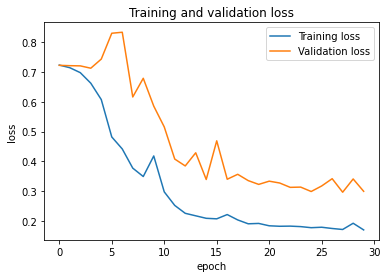

In [11]:
# Plot accuracy progression for training and validation
plt.figure()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Training and validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
#plt.ylim([0.50, 1.00])
plt.legend(['Training accuracy', 'Validation accuracy'], loc='lower right')

#plt.savefig('acc_modelo', dpi=300, bbox_inches='tight')
plt.show()

# Plot loss progression for training and validation
plt.figure()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Training and validation loss')
plt.ylabel('loss')
plt.xlabel('epoch')
#plt.ylim([0.00, 0.70])
plt.legend(['Training loss', 'Validation loss'], loc='upper right')

#plt.savefig('loss_modelo', dpi=300, bbox_inches='tight')
plt.show()


Seguidamente, para la observación visual de la evaluación del modelo se crea la matriz de confusión, junto a otras métricas. Para ello se hace la predicción mediante "predict" y se establece el umbral de 0.5 para decantarse por una clase u otra, siendo 0 no esquistocitos y 1 esquistocitos.

In [12]:
predictions = model.predict(test_generator,
                            steps=muestras_test,
                            verbose=1)
predictions

1400/1400 [==============================] - 5s 4ms/step


array([[0.00850699],
       [0.01582029],
       [0.01027954],
       ...,
       [0.36342672],
       [0.9941744 ],
       [0.9944296 ]], dtype=float32)

In [13]:
y_pred=[]
for i in predictions:
    if i < 0.5:
        i=0
        y_pred.append(i)
    else:
        i=1
        y_pred.append(i)
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [14]:
true_class = test_generator.classes
print (true_class)
class_labels = list(test_generator.class_indices.keys())
print (class_labels)

[0 0 0 ... 1 1 1]
['0_no_esquistocitos', '1_esquistocitos']


                    precision    recall  f1-score   support

0_no_esquistocitos     0.8573    0.9443    0.8987       700
   1_esquistocitos     0.9380    0.8429    0.8879       700

          accuracy                         0.8936      1400
         macro avg     0.8977    0.8936    0.8933      1400
      weighted avg     0.8977    0.8936    0.8933      1400



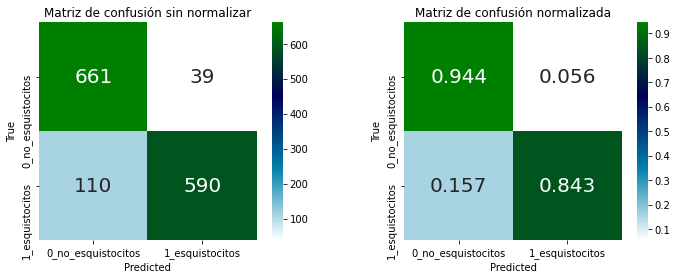

In [16]:
from sklearn import metrics
from sklearn.metrics import confusion_matrix, classification_report, precision_score, accuracy_score
import pandas as pd
import seaborn as sns

# Classification report
report = metrics.classification_report(true_class, y_pred, target_names=class_labels, digits=4)
print (report)

# Confusion matrix
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
cm = confusion_matrix(true_class, y_pred)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
cm_df
ax=sns.heatmap(cm_df, annot=True, fmt='2.0f', cmap='ocean_r',
               cbar=True, square=True, annot_kws={'fontsize':20})
ax.set_title('Matriz de confusión sin normalizar')

ax = fig.add_subplot(1,2,2)
cm = confusion_matrix(true_class, y_pred, normalize='true')
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
cm_df
ax=sns.heatmap(cm_df, annot=True, fmt='2.3f', cmap='ocean_r',
               cbar=True, square=True, annot_kws={'fontsize':20})
ax.set_title('Matriz de confusión normalizada')
#plt.savefig('cm_modelo', dpi=300, bbox_inches='tight')
plt.show()

Además se grafica la curva ROC con la que se obtiene el área bajo la curva. 

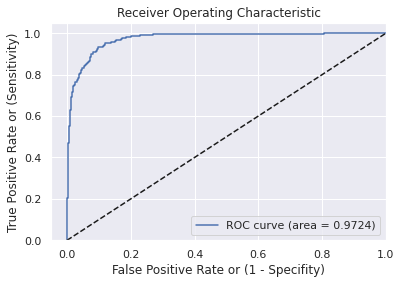

In [17]:
from sklearn.metrics import roc_curve, auc

fpr, tpr, thresholds = roc_curve(true_class, predictions, pos_label=1)
roc_auc = auc(fpr, tpr) #auc = area under curve

# Grafica ROC curve
sns.set(font_scale=1)
plt.plot(fpr, tpr, label='ROC curve (area = %0.4f)' % roc_auc)
plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([-0.05, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate or (1 - Specifity)')
plt.ylabel('True Positive Rate or (Sensitivity)')
plt.title('Receiver Operating Characteristic')
plt.legend(loc="lower right")
#plt.savefig('roc_modelo', dpi=300, bbox_inches='tight')
plt.show()

El umbral establecido hasta ahora para la clasificación era de 0.5. Las células con una probabilidad superior a 0.5 se clasificaban como esquistocitos, y de lo contrario, como no esquistocitos. Sin embargo, si el umbral se cambia puede haber una mejora de los resultados.

La siguiente comanda maximiza el umbral de la curva ROC.

In [18]:
ix = np.argmax(tpr*(1-fpr))
ix_th = thresholds[ix]
print('Best Threshold=%f' % (ix_th))

Best Threshold=0.258958


Al disminuir el umbral, la sensibilidad aumenta y, por tanto, habrá esquistocitos mejor clasificados. Para comprobarlo se vuelven a calcular las métricas incluidas las matrices de confusión.

In [19]:
y_pred=[]
for i in predictions:
    if i < ix_th:
        i=0
        y_pred.append(i)
    else:
        i=1
        y_pred.append(i)
y_pred

[0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 1,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,
 0,


In [20]:
true_class = test_generator.classes
print (true_class)
class_labels = list(test_generator.class_indices.keys())
print (class_labels)

[0 0 0 ... 1 1 1]
['0_no_esquistocitos', '1_esquistocitos']


                    precision    recall  f1-score   support

0_no_esquistocitos     0.9295    0.9043    0.9167       700
   1_esquistocitos     0.9068    0.9314    0.9190       700

          accuracy                         0.9179      1400
         macro avg     0.9182    0.9179    0.9178      1400
      weighted avg     0.9182    0.9179    0.9178      1400



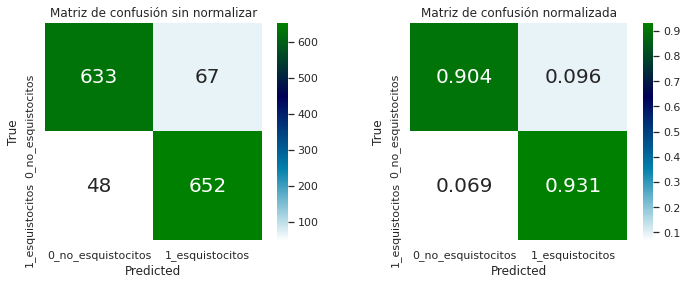

In [22]:
# Classification report
report = metrics.classification_report(true_class, y_pred, target_names=class_labels, digits=4)
print (report)

# Confusion matrix
fig = plt.figure(figsize=(12,4))

ax = fig.add_subplot(1,2,1)
cm = confusion_matrix(true_class, y_pred)
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
cm_df
ax=sns.heatmap(cm_df, annot=True, fmt='2.0f', cmap='ocean_r',
               cbar=True, square=True, annot_kws={'fontsize':20})
ax.set_title('Matriz de confusión sin normalizar')

ax = fig.add_subplot(1,2,2)
cm = confusion_matrix(true_class, y_pred, normalize='true')
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
cm_df.index.name = 'True'
cm_df.columns.name = 'Predicted'
cm_df
ax=sns.heatmap(cm_df, annot=True, fmt='2.3f', cmap='ocean_r',
               cbar=True, square=True, annot_kws={'fontsize':20})
ax.set_title('Matriz de confusión normalizada')
#plt.savefig('cm_modelo', dpi=300, bbox_inches='tight')
plt.show()

Como se observa en las matrices de confusión, el clasificador es mejor que el anterior.

Para terminar, se visualizan las imágenes mal clasificadas mediante dos bucles while, especificando la clase verdadera (t) y la clase predicha (p). Esto puede dar una idea sobre qué características no ha extraído el modelo.

In [23]:
import PIL
from PIL import Image
from keras.preprocessing.image import load_img
import PIL

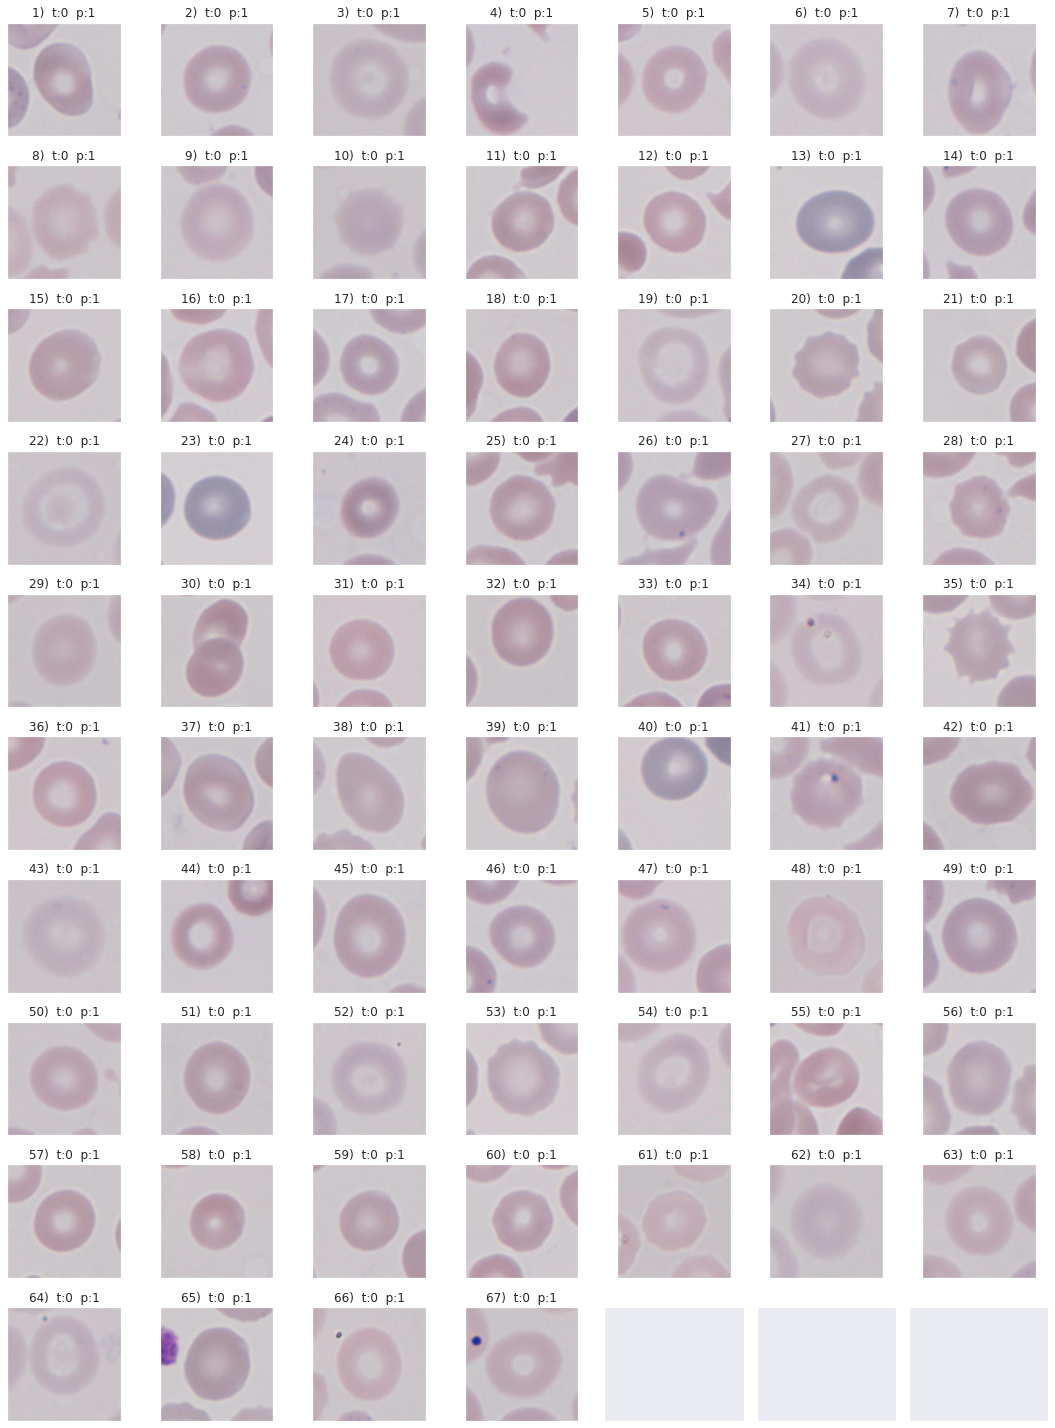

67 imágenes de NO esquistocitos clasificadas como esquistocitos


In [24]:
fig, ax = plt.subplots(nrows=10, ncols=7, sharex=True, sharey=True, figsize=(15,20))
ax = ax.flatten()
imagenes=[]

i=0
j=0
while i < 700:
    if y_pred[i] == 1:
        complete = os.path.join(test_noesq_dir, os.listdir(test_noesq_dir)[i])
        img = load_img(complete)
        ax[j].imshow(img)
        ax[j].set_title('%d)  t:0  p:1' % (j+1))
        imagenes.append(i)
        j=j+1
        
    else:
        pass
    i=i+1

ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('noesq_mal_modelo', dpi=300, bbox_inches='tight')
plt.show()
print('{} imágenes de NO esquistocitos clasificadas como esquistocitos'.format(len(imagenes)))

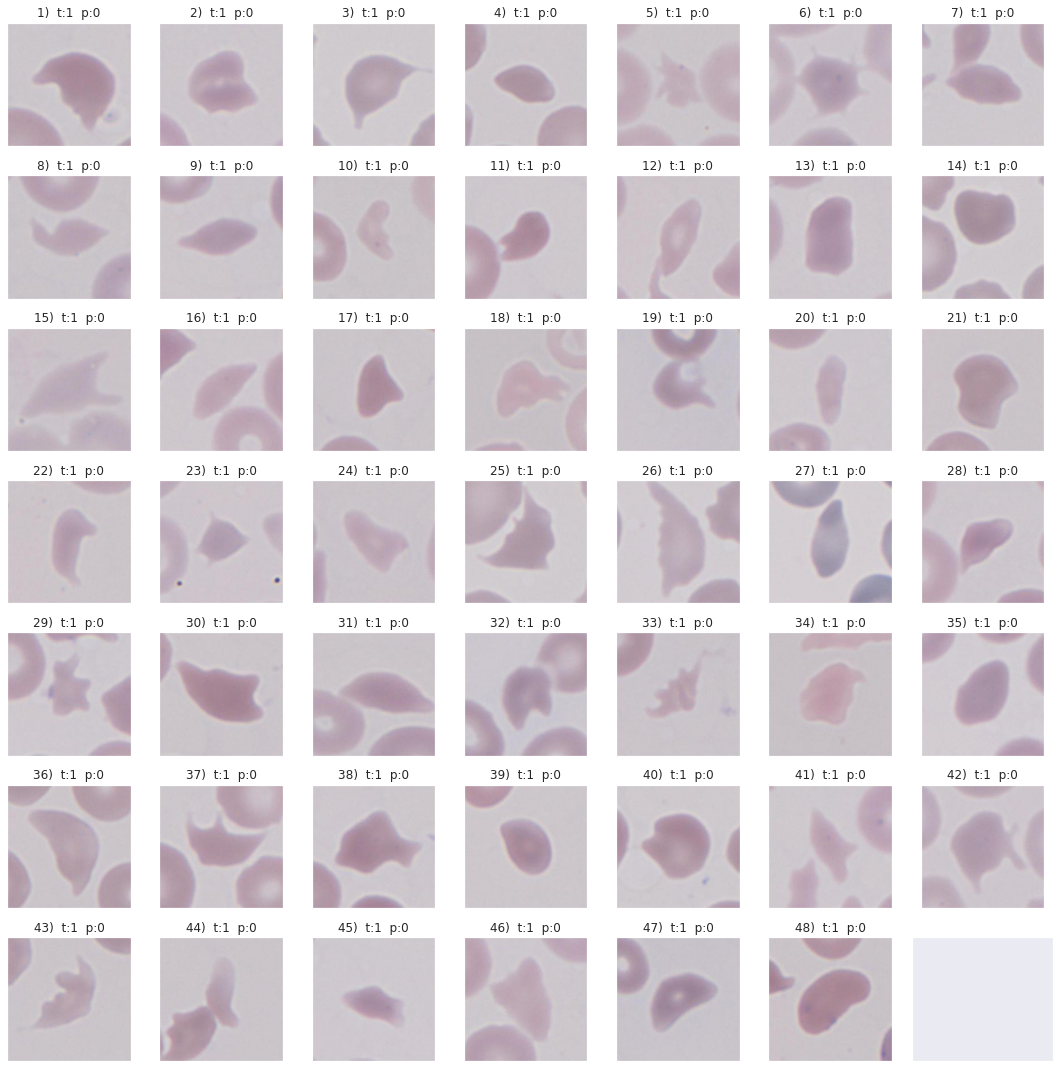

48 imágenes de esquistocitos clasificadas como NO esquistocitos


In [25]:
fig, ax = plt.subplots(nrows=7, ncols=7, sharex=True, sharey=True, figsize=(15,15))
ax = ax.flatten()
imagenes=[]

i=0
j=0
while i < 700:
    if y_pred[700:][i] == 0:
        complete = os.path.join(test_esq_dir, os.listdir(test_esq_dir)[i])
        img = load_img(complete)
        ax[j].imshow(img)
        ax[j].set_title('%d)  t:1  p:0' % (j+1))
        imagenes.append(i)
        j=j+1
        
    else:
        pass
    i=i+1
ax[0].set_xticks([])
ax[0].set_yticks([])
plt.tight_layout()
#plt.savefig('esq_mal_modelo', dpi=300, bbox_inches='tight')
plt.show()
print('{} imágenes de esquistocitos clasificadas como NO esquistocitos'.format(len(imagenes)))

En las imágenes de no esquistocitos mal clasificadas, se observa que hay algunas que podrían pertenecer a una alteración morfológica diferente de la esquistocitosis. En cambio, en las imágenes de esquistocitos mal clasificadas, al ser una alteración con variabilidad de forma, puede haber clasificado correctamente aquellas más comunes.
Además, muchas imágenes mal clasificadas presentan otras células diferentes a la central que es la que se desea analizar.

Sin embargo, el algoritmo no ha sabido clasificar algunas imágenes que parecen claras de pertenecer a su clase. Este hecho podría deberse, entre otros factores, a la falta de imágenes en los datos iniciales.